# Import libraries

In [1]:
import pandas as pd
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# miscellaneous
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('train.csv')

In [4]:


from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)


# V.1 Train basic XGBoost model
Result: AUC 0.6420 | Gini 0.2840

Features:
ps_car_11_cat    0.407947 
ps_car_06_cat    0.070341
ps_ind_05_cat    0.054751
ps_car_01_cat    0.053407
ps_car_04_cat    0.048554
ps_car_09_cat    0.026072
ps_car_07_cat    0.025671
ps_ind_02_cat    0.022840
ps_car_03_cat    0.019266
ps_ind_06_bin    0.015198
ps_ind_17_bin    0.014360
ps_car_02_cat    0.013458
ps_ind_04_cat    0.012683
ps_car_05_cat    0.012305
ps_car_13        0.010133

# V.2 Manual randomized hyperparameter search
Same code, checking if I can get similar results

Result: Best model TEST AUC: 0.643 822  Best model TEST Gini: 0.287 645

Features: ps_car_11_cat    0.384534
ps_car_06_cat    0.065064
ps_ind_05_cat    0.057773
ps_car_01_cat    0.054636
ps_car_04_cat    0.048807
ps_car_07_cat    0.032596
ps_car_09_cat    0.027361
ps_car_03_cat    0.023746
ps_ind_02_cat    0.021768
ps_ind_06_bin    0.019985
ps_ind_17_bin    0.017678
ps_car_02_cat    0.012677
ps_car_13        0.012593
ps_ind_04_cat    0.012507
ps_car_05_cat    0.012062

In [50]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

def sample_params(rng: np.random.Generator) -> dict:
    return {
        "max_depth": int(rng.choice([3, 4, 5, 6])),
        "min_child_weight": int(rng.choice([1, 2, 5, 10])),
        "subsample": float(rng.choice([0.7, 0.8, 0.9, 1.0])),
        "colsample_bytree": float(rng.choice([0.6, 0.7, 0.8, 0.9, 1.0])),
        "gamma": float(rng.choice([0.0, 0.05, 0.1, 0.2])),
        "reg_lambda": float(rng.choice([1.0, 2.0, 5.0, 10.0])),
        "reg_alpha": float(rng.choice([0.0, 0.001, 0.01, 0.1])),
    }

base = dict(
    n_estimators=2000,          # lower cap
    learning_rate=0.02,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=pos_weight,
    early_stopping_rounds=200,
)

rng = np.random.default_rng(42)

best_auc = -1.0
best_model = None
best_params = None

for t in range(12):  # 10–15 is laptop-safe
    params = sample_params(rng)
    model = XGBClassifier(**base, **params)

    model.fit(
        X_train_enc, y_train,
        eval_set=[(X_val_enc, y_val)],
        verbose=False
    )

    val_pred = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val, val_pred)

    print(f"trial {t+1:02d} | val_auc={auc:.6f} | best_iter={model.best_iteration} | {params}")

    if auc > best_auc:
        best_auc = auc
        best_model = model
        best_params = params

print("\nBEST")
print("val_auc:", best_auc)
print("params:", best_params)


trial 01 | val_auc=0.641699 | best_iter=591 | {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0.05, 'reg_lambda': 10.0, 'reg_alpha': 0.0}
trial 02 | val_auc=0.642117 | best_iter=355 | {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'gamma': 0.2, 'reg_lambda': 5.0, 'reg_alpha': 0.1}
trial 03 | val_auc=0.643253 | best_iter=289 | {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 0.2, 'reg_lambda': 2.0, 'reg_alpha': 0.01}
trial 04 | val_auc=0.640834 | best_iter=336 | {'max_depth': 4, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0, 'reg_alpha': 0.1}
trial 05 | val_auc=0.643840 | best_iter=327 | {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.0, 'reg_lambda': 5.0, 'reg_alpha': 0.1}
trial 06 | val_auc=0.640291 | best_iter=463 | {'max_depth': 3, 'min_child_weight': 10, 'subsamp

In [52]:
test_proba = best_model.predict_proba(X_test_enc)[:, 1]

test_auc = roc_auc_score(y_test, test_proba)
test_gini = 2 * test_auc - 1

print("Best model TEST AUC:", test_auc)
print("Best model TEST Gini:", test_gini)



Best model TEST AUC: 0.6438225101965773
Best model TEST Gini: 0.28764502039315465


In [53]:
expanded_importance = pd.Series(
    best_model.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

expanded_importance.head(20)

def original_feature_name(name: str) -> str:
    # remove ColumnTransformer prefix
    name = name.split("__", 1)[-1]

    # collapse OHE categories back to base feature
    if "_cat" in name:
        return name.split("_cat", 1)[0] + "_cat"
    return name

aggregated_importance = (
    expanded_importance
    .groupby(expanded_importance.index.map(original_feature_name))
    .sum()
    .sort_values(ascending=False)
)

aggregated_importance.head(15)



ps_car_11_cat    0.384534
ps_car_06_cat    0.065064
ps_ind_05_cat    0.057773
ps_car_01_cat    0.054636
ps_car_04_cat    0.048807
ps_car_07_cat    0.032596
ps_car_09_cat    0.027361
ps_car_03_cat    0.023746
ps_ind_02_cat    0.021768
ps_ind_06_bin    0.019985
ps_ind_17_bin    0.017678
ps_car_02_cat    0.012677
ps_car_13        0.012593
ps_ind_04_cat    0.012507
ps_car_05_cat    0.012062
dtype: float32

# Confusion matrix, ROC, precision-recall

<Figure size 640x480 with 0 Axes>

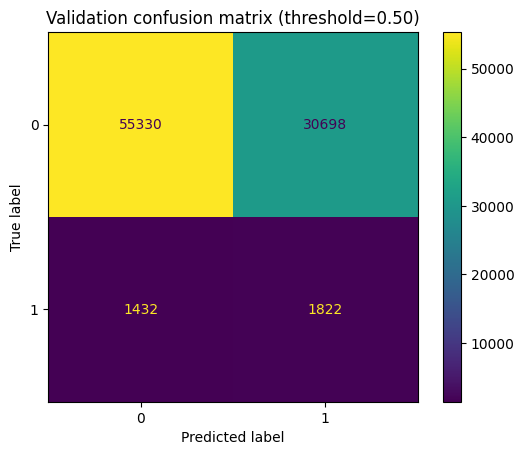

              precision    recall  f1-score   support

           0     0.9748    0.6432    0.7750     86028
           1     0.0560    0.5599    0.1019      3254

    accuracy                         0.6401     89282
   macro avg     0.5154    0.6015    0.4384     89282
weighted avg     0.9413    0.6401    0.7505     89282



<Figure size 640x480 with 0 Axes>

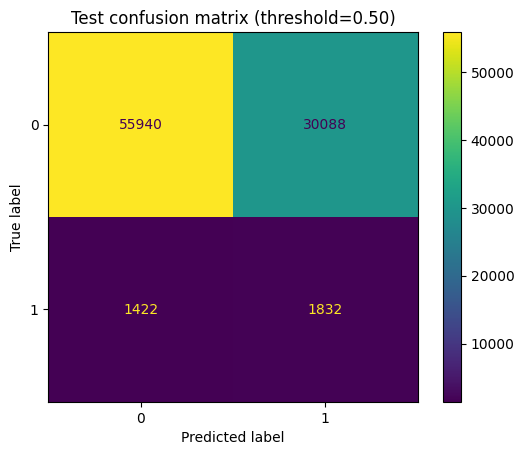

              precision    recall  f1-score   support

           0     0.9752    0.6503    0.7802     86028
           1     0.0574    0.5630    0.1042      3254

    accuracy                         0.6471     89282
   macro avg     0.5163    0.6066    0.4422     89282
weighted avg     0.9418    0.6471    0.7556     89282



array([[55940, 30088],
       [ 1422,  1832]])

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def show_confusion(y_true, y_proba, threshold=0.5, title="Confusion matrix"):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"{title} (threshold={threshold:.2f})")
    plt.show()

    print(classification_report(y_true, y_pred, digits=4))
    return cm

# Validation
show_confusion(y_val, val_proba, threshold=0.50, title="Validation confusion matrix")

# Test
show_confusion(y_test, test_proba, threshold=0.50, title="Test confusion matrix")


Best threshold (by F1 on val): 0.59 F1: 0.11722285067873303


<Figure size 640x480 with 0 Axes>

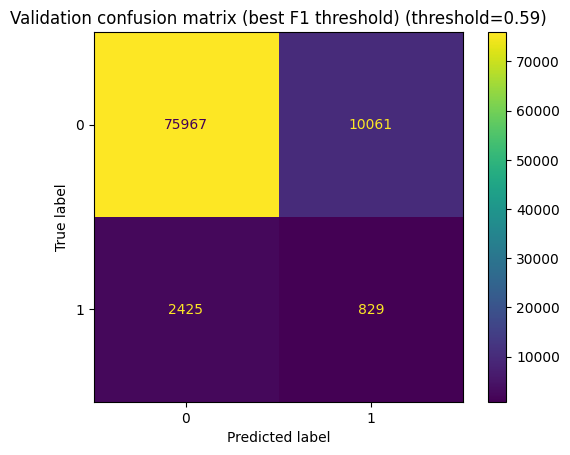

              precision    recall  f1-score   support

           0     0.9691    0.8830    0.9241     86028
           1     0.0761    0.2548    0.1172      3254

    accuracy                         0.8602     89282
   macro avg     0.5226    0.5689    0.5206     89282
weighted avg     0.9365    0.8602    0.8947     89282



<Figure size 640x480 with 0 Axes>

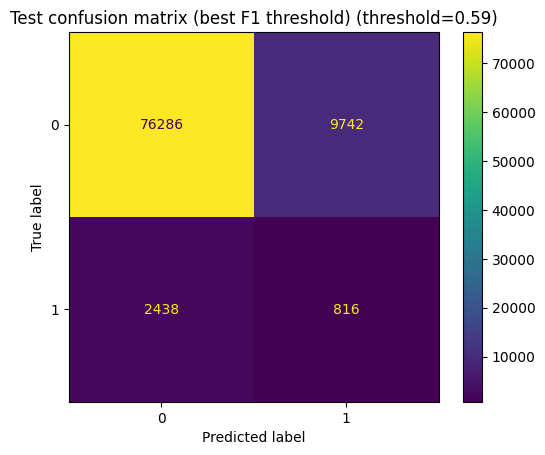

              precision    recall  f1-score   support

           0     0.9690    0.8868    0.9261     86028
           1     0.0773    0.2508    0.1182      3254

    accuracy                         0.8636     89282
   macro avg     0.5232    0.5688    0.5221     89282
weighted avg     0.9365    0.8636    0.8966     89282



array([[76286,  9742],
       [ 2438,   816]])

In [13]:
from sklearn.metrics import f1_score

def best_threshold_by_f1(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    scores = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        scores.append(f1_score(y_true, y_pred))
    best_idx = int(np.argmax(scores))
    return float(thresholds[best_idx]), float(scores[best_idx])

t_star, f1_star = best_threshold_by_f1(y_val, val_proba)
print("Best threshold (by F1 on val):", t_star, "F1:", f1_star)

show_confusion(y_val, val_proba, threshold=t_star, title="Validation confusion matrix (best F1 threshold)")
show_confusion(y_test, test_proba, threshold=t_star, title="Test confusion matrix (best F1 threshold)")


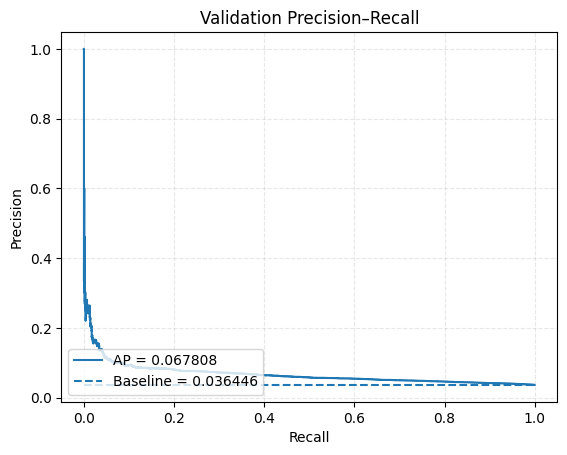

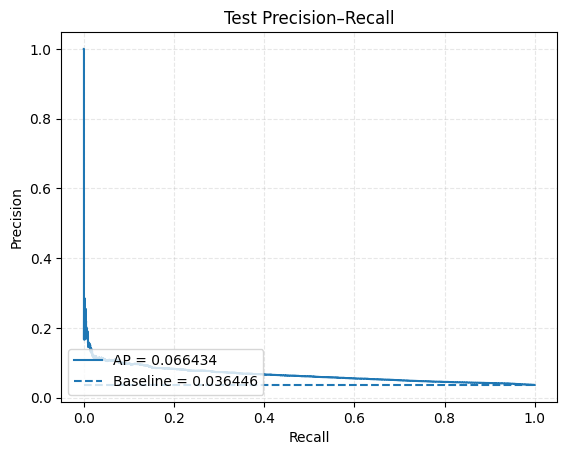

Val AP:  0.067808
Test AP: 0.066434


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(y_true, y_proba, title="Precision–Recall curve"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    # baseline = positive class prevalence
    baseline = float(np.mean(y_true))

    plt.figure()
    plt.plot(recall, precision, label=f"AP = {ap:.6f}")
    plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline = {baseline:.6f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

    return ap

# probabilities from your trained model
val_proba = best_model.predict_proba(X_val_enc)[:, 1] if "best_model" in globals() else model.predict_proba(X_val_enc)[:, 1]
test_proba = best_model.predict_proba(X_test_enc)[:, 1] if "best_model" in globals() else model.predict_proba(X_test_enc)[:, 1]

val_ap = plot_pr(y_val, val_proba, title="Validation Precision–Recall")
test_ap = plot_pr(y_test, test_proba, title="Test Precision–Recall")

print(f"Val AP:  {val_ap:.6f}")
print(f"Test AP: {test_ap:.6f}")


Val AUC: 0.6428185650394581
Val Gini: 0.2856371300789162
Test AUC: 0.6445053059296113
Test Gini: 0.2890106118592226


# V.3 Finetuning iteration, trying to improve gini

Change: drop calc columns, OHE, replace -1 with nan

Result: Test AUC: 0.646010 | Test Gini: 0.292 020

10	ps_car_11	0.434405
5	ps_car_06	0.073395
19	ps_ind_05	0.066395
0	ps_car_01	0.056828
3	ps_car_04	0.054692
6	ps_car_07	0.029688
8	ps_car_09	0.027914
2	ps_car_03	0.023360
16	ps_ind_02	0.021320
20	ps_ind_06_bin	0.019636

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Replace -1 with NaN (common in some datasets)
df2 = df.replace(-1, np.nan)

TARGET = "target"
ID_COL = "id"

# Robust drop (won't error if a column is missing)
drop_cols = [
    TARGET, ID_COL,
    'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
    'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
    'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
    'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
    'ps_calc_19_bin', 'ps_calc_20_bin'
]

X2 = df2.drop(columns=drop_cols, errors="ignore")
y2 = df2[TARGET].astype("int64")  # assumes target has no NaNs

# Define columns based on X2 (IMPORTANT)
cat_cols = [c for c in X2.columns if c.endswith("_cat")]
num_cols = [c for c in X2.columns if c not in cat_cols]

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(
    X2, y2, test_size=0.30, random_state=42, stratify=y2
)
X_val2, X_test2, y_val2, y_test2 = train_test_split(
    X_temp2, y_temp2, test_size=0.50, random_state=42, stratify=y_temp2
)

print("Train:", X_train2.shape, "Val:", X_val2.shape, "Test:", X_test2.shape)
print("Cat cols:", len(cat_cols), "Num cols:", len(num_cols))
print("Target rate (train):", y_train2.mean())

# Preprocess: OHE for cat, passthrough numeric.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

pos_weight = (y_train2 == 0).sum() / (y_train2 == 1).sum()

xgb = XGBClassifier(
    n_estimators=6000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.0,
    reg_lambda=5.0,
    reg_alpha=0.1,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=pos_weight,
    early_stopping_rounds=300,
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb),
])

# IMPORTANT: pass eval_set in transformed space.
# Easiest: preprocess train/val once here.
X_train_tr = preprocessor.fit_transform(X_train2)
X_val_tr   = preprocessor.transform(X_val2)
X_test_tr  = preprocessor.transform(X_test2)

xgb.fit(
    X_train_tr, y_train2,
    eval_set=[(X_val_tr, y_val2)],
    verbose=50
)

print("Best iteration:", getattr(xgb, "best_iteration", None))

val_proba2  = xgb.predict_proba(X_val_tr)[:, 1]
test_proba2 = xgb.predict_proba(X_test_tr)[:, 1]

val_auc  = roc_auc_score(y_val2, val_proba2)
test_auc = roc_auc_score(y_test2, test_proba2)

val_gini  = 2 * val_auc - 1
test_gini = 2 * test_auc - 1

print(f"Val AUC:  {val_auc:.6f} | Val Gini:  {val_gini:.6f}")
print(f"Test AUC: {test_auc:.6f} | Test Gini: {test_gini:.6f}")


Train: (416648, 37) Val: (89282, 37) Test: (89282, 37)
Cat cols: 14 Num cols: 23
Target rate (train): 0.03644803287187266
[0]	validation_0-auc:0.59634
[50]	validation_0-auc:0.62746
[100]	validation_0-auc:0.63023
[150]	validation_0-auc:0.63357
[200]	validation_0-auc:0.63615
[250]	validation_0-auc:0.63793
[300]	validation_0-auc:0.63912
[350]	validation_0-auc:0.64012
[400]	validation_0-auc:0.64100
[450]	validation_0-auc:0.64151
[500]	validation_0-auc:0.64179
[550]	validation_0-auc:0.64206
[600]	validation_0-auc:0.64193
[650]	validation_0-auc:0.64199
[700]	validation_0-auc:0.64208
[750]	validation_0-auc:0.64204
[800]	validation_0-auc:0.64204
[850]	validation_0-auc:0.64199
[900]	validation_0-auc:0.64192
[950]	validation_0-auc:0.64178
[1000]	validation_0-auc:0.64171
[1050]	validation_0-auc:0.64168
[1100]	validation_0-auc:0.64150
[1113]	validation_0-auc:0.64144
Best iteration: 813
Val AUC:  0.642106 | Val Gini:  0.284213
Test AUC: 0.646010 | Test Gini: 0.292020


In [70]:
# Get trained components
ohe = preprocessor.named_transformers_["cat"]
num_features = num_cols

# OHE feature names
cat_feature_names = ohe.get_feature_names_out(cat_cols)

# Full feature list in correct order
feature_names = np.concatenate([cat_feature_names, num_features])



importances = xgb.feature_importances_

feat_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feat_imp["base_feature"] = feat_imp["feature"].str.split("_cat_").str[0]

agg_imp = (
    feat_imp
    .groupby("base_feature", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)
agg_imp.head(20)


,base_feature,importance
10,ps_car_11,0.434405
5,ps_car_06,0.073395
19,ps_ind_05,0.066395
0,ps_car_01,0.056828
3,ps_car_04,0.054692
6,ps_car_07,0.029688
8,ps_car_09,0.027914
2,ps_car_03,0.023360
16,ps_ind_02,0.021320
20,ps_ind_06_bin,0.019636


# V.4 Seed-based ensemble of XGBoost models

Result: Ensemble Test AUC: 0.645 761  Ensemble Test Gini: 0.291 522

Conclusion: ensemble is worse because the individual models are too similar, and we are averaging away useful signal along with noise.

# V.5 5-fold cross-validation

CV AUC: 0.640 615
CV Gini: 0.281 231

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import gc  # Garbage collection
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv('train.csv')
TARGET = "target"
ID_COL = "id"
cat_cols = [c for c in df.columns if c.endswith("_cat")]
num_cols = [c for c in df.columns if c not in cat_cols + [TARGET, ID_COL]]

X = df.drop(columns=[TARGET, ID_COL])
y = df[TARGET].astype(int)

# ============================================================================
# MEMORY-EFFICIENT FEATURE ENGINEERING
# ============================================================================

def create_features(X_in, cat_cols, freq_maps=None, missing_cols=None, is_train=True):
    """Lightweight feature engineering - only essential features"""
    X = X_in.copy()
    
    # 1. Missing value indicators - FIXED to handle consistent columns
    if is_train:
        missing_cols = []
        for col in X.columns:
            if (X[col] == -1).any():
                missing_cols.append(col)
    
    # Create missing indicators for all tracked columns
    for col in missing_cols if not is_train else X.columns:
        if col in X.columns and (is_train or col in missing_cols):
            if (X[col] == -1).any() or not is_train:
                X[f'{col}_is_missing'] = (X[col] == -1).astype(int)
    
    # 2. Frequency encoding (most important from your analysis)
    if is_train:
        freq_maps = {}
        for c in cat_cols:
            freq = X[c].value_counts(dropna=False) / len(X)
            freq_maps[c] = freq
            X[c + "_freq"] = X[c].map(freq).astype('float32')  # Use float32 to save memory
    else:
        for c in cat_cols:
            X[c + "_freq"] = X[c].map(freq_maps[c]).fillna(0).astype('float32')
    
    # 3. Only add top 2-3 interactions based on feature importance
    if 'ps_car_13' in X.columns and 'ps_ind_03' in X.columns:
        X['car13_x_ind03'] = (X['ps_car_13'] * X['ps_ind_03']).astype('float32')
    
    if 'ps_reg_01' in X.columns and 'ps_reg_02' in X.columns:
        X['reg_sum'] = (X['ps_reg_01'] + X['ps_reg_02']).astype('float32')
    
    return X, freq_maps, missing_cols

# ============================================================================
# MEMORY-EFFICIENT CV - STRATEGY 1: DON'T STORE MODELS
# ============================================================================

def cv_score_only(X, y, n_splits=5, params=None):
    """
    Get CV score without storing models.
    PROS: Minimal memory usage
    CONS: Can't use models for prediction later
    """
    
    if params is None:
        pos_weight = (y == 0).sum() / (y == 1).sum()
        params = {
            'n_estimators': 2000,  # Lower for speed
            'learning_rate': 0.02,
            'max_depth': 5,
            'min_child_weight': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.0,
            'reg_lambda': 10.0,
            'reg_alpha': 0.0,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'hist',
            'scale_pos_weight': pos_weight,
            'early_stopping_rounds': 150,
            'random_state': 42,
            'n_jobs': 1  # Limit parallel jobs to save memory
        }
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X), dtype='float32')  # Use float32
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}/{n_splits}")
        
        # Work with views/indices instead of copies where possible
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Feature engineering - FIXED
        X_train_fe, freq_maps, missing_cols = create_features(X_train_fold, cat_cols, is_train=True)
        X_val_fe, _, _ = create_features(X_val_fold, cat_cols, freq_maps=freq_maps, 
                                         missing_cols=missing_cols, is_train=False)
        
        # Get numeric columns after FE
        num_cols_fe = [c for c in X_train_fe.columns if c not in cat_cols]
        
        # Use sparse output for one-hot encoding to save memory
        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype='float32'), cat_cols),
                ("num", "passthrough", num_cols_fe),
            ]
        )
        
        X_train_enc = preprocessor.fit_transform(X_train_fe)
        X_val_enc = preprocessor.transform(X_val_fe)
        
        # Train model
        model = XGBClassifier(**params)
        model.fit(
            X_train_enc, y_train_fold,
            eval_set=[(X_val_enc, y_val_fold)],
            verbose=100
        )
        
        # Get predictions
        oof_preds[val_idx] = model.predict_proba(X_val_enc)[:, 1]
        fold_auc = roc_auc_score(y_val_fold, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        
        print(f"Fold {fold} AUC: {fold_auc:.6f} | Gini: {2*fold_auc - 1:.6f}")
        
        # CRITICAL: Delete objects and force garbage collection
        del X_train_fe, X_val_fe, X_train_enc, X_val_enc, model, preprocessor
        gc.collect()
    
    overall_auc = roc_auc_score(y, oof_preds)
    print(f"\n{'='*50}")
    print(f"CV AUC: {overall_auc:.6f} ± {np.std(fold_scores):.6f}")
    print(f"CV Gini: {2*overall_auc - 1:.6f}")
    print(f"{'='*50}")
    
    return overall_auc, oof_preds

# ============================================================================
# MEMORY-EFFICIENT CV - STRATEGY 2: STORE ONLY BEST MODEL
# ============================================================================

def cv_with_best_model(X, y, n_splits=5, params=None):
    """
    Store only the best performing fold's model.
    PROS: Keeps one model for later use
    CONS: Slightly more memory than Strategy 1
    """
    
    if params is None:
        pos_weight = (y == 0).sum() / (y == 1).sum()
        params = {
            'n_estimators': 2000,
            'learning_rate': 0.02,
            'max_depth': 5,
            'min_child_weight': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.0,
            'reg_lambda': 10.0,
            'reg_alpha': 0.0,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'hist',
            'scale_pos_weight': pos_weight,
            'early_stopping_rounds': 150,
            'random_state': 42,
            'n_jobs': 1
        }
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X), dtype='float32')
    
    best_auc = -1
    best_model = None
    best_preprocessor = None
    best_freq_maps = None
    best_num_cols = None
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}/{n_splits}")
        
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Feature engineering - FIXED
        X_train_fe, freq_maps, missing_cols = create_features(X_train_fold, cat_cols, is_train=True)
        X_val_fe, _, _ = create_features(X_val_fold, cat_cols, freq_maps=freq_maps,
                                         missing_cols=missing_cols, is_train=False)
        
        num_cols_fe = [c for c in X_train_fe.columns if c not in cat_cols]
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype='float32'), cat_cols),
                ("num", "passthrough", num_cols_fe),
            ]
        )
        
        X_train_enc = preprocessor.fit_transform(X_train_fe)
        X_val_enc = preprocessor.transform(X_val_fe)
        
        model = XGBClassifier(**params)
        model.fit(
            X_train_enc, y_train_fold,
            eval_set=[(X_val_enc, y_val_fold)],
            verbose=100
        )
        
        oof_preds[val_idx] = model.predict_proba(X_val_enc)[:, 1]
        fold_auc = roc_auc_score(y_val_fold, oof_preds[val_idx])
        
        print(f"Fold {fold} AUC: {fold_auc:.6f} | Gini: {2*fold_auc - 1:.6f}")
        
        # Keep only the best model
        if fold_auc > best_auc:
            best_auc = fold_auc
            # Delete old best model if it exists
            if best_model is not None:
                del best_model
                gc.collect()
            best_model = model
            best_preprocessor = preprocessor
            best_freq_maps = freq_maps
            best_num_cols = num_cols_fe
        else:
            # Delete this fold's model
            del model, preprocessor
            gc.collect()
        
        # Always delete fold data
        del X_train_fe, X_val_fe, X_train_enc, X_val_enc
        gc.collect()
    
    overall_auc = roc_auc_score(y, oof_preds)
    print(f"\n{'='*50}")
    print(f"CV AUC: {overall_auc:.6f}")
    print(f"CV Gini: {2*overall_auc - 1:.6f}")
    print(f"Best fold AUC: {best_auc:.6f}")
    print(f"{'='*50}")
    
    return overall_auc, oof_preds, best_model, best_preprocessor, best_freq_maps, best_num_cols

# ============================================================================
# MEMORY-EFFICIENT CV - STRATEGY 3: FEWER FOLDS OR HOLDOUT
# ============================================================================

def simple_holdout_validation(X, y, test_size=0.2, params=None):
    """
    Simple train/val split instead of CV.
    PROS: Fastest, least memory
    CONS: Less reliable estimate than CV
    """
    from sklearn.model_selection import train_test_split
    
    if params is None:
        pos_weight = (y == 0).sum() / (y == 1).sum()
        params = {
            'n_estimators': 3000,
            'learning_rate': 0.02,
            'max_depth': 5,
            'min_child_weight': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.0,
            'reg_lambda': 10.0,
            'reg_alpha': 0.0,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'hist',
            'scale_pos_weight': pos_weight,
            'early_stopping_rounds': 200,
            'random_state': 42,
            'n_jobs': 1
        }
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Feature engineering
    X_train_fe, freq_maps, missing_cols = create_features(X_train, cat_cols, is_train=True)
    X_val_fe, _, _ = create_features(X_val, cat_cols, freq_maps=freq_maps,
                                     missing_cols=missing_cols, is_train=False)
    
    num_cols_fe = [c for c in X_train_fe.columns if c not in cat_cols]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype='float32'), cat_cols),
            ("num", "passthrough", num_cols_fe),
        ]
    )
    
    X_train_enc = preprocessor.fit_transform(X_train_fe)
    X_val_enc = preprocessor.transform(X_val_fe)
    
    print(f"Train shape: {X_train_enc.shape}, Val shape: {X_val_enc.shape}")
    
    model = XGBClassifier(**params)
    model.fit(
        X_train_enc, y_train,
        eval_set=[(X_val_enc, y_val)],
        verbose=50
    )
    
    val_preds = model.predict_proba(X_val_enc)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    
    print(f"\nValidation AUC: {val_auc:.6f}")
    print(f"Validation Gini: {2*val_auc - 1:.6f}")
    
    return model, preprocessor, freq_maps, num_cols_fe, val_auc

# ============================================================================
# LIGHTWEIGHT HYPERPARAMETER SEARCH WITH CV
# ============================================================================

def lightweight_param_search(X, y, n_trials=10, n_splits=3):
    """
    Memory-efficient parameter search using fewer CV folds.
    """
    pos_weight = (y == 0).sum() / (y == 1).sum()
    
    base_params = {
        'n_estimators': 1500,  # Lower for speed
        'learning_rate': 0.02,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'scale_pos_weight': pos_weight,
        'early_stopping_rounds': 100,
        'random_state': 42,
        'n_jobs': 1
    }
    
    param_space = {
        "max_depth": [4, 5, 6],
        "min_child_weight": [1, 2, 5, 10],
        "subsample": [0.7, 0.8, 0.9],
        "colsample_bytree": [0.6, 0.7, 0.8],
        "gamma": [0.0, 0.05, 0.1],
        "reg_lambda": [2.0, 5.0, 10.0],
        "reg_alpha": [0.0, 0.01, 0.1],
    }
    
    rng = np.random.default_rng(42)
    best_score = -1
    best_params = None
    
    for trial in range(n_trials):
        # Sample random params
        trial_params = {
            key: rng.choice(values) 
            for key, values in param_space.items()
        }
        trial_params.update(base_params)
        
        print(f"\n{'='*60}")
        print(f"Trial {trial+1}/{n_trials}")
        print(f"Params: {trial_params}")
        print(f"{'='*60}")
        
        # Use fewer folds (3 instead of 5) to save memory
        score, _ = cv_score_only(X, y, n_splits=n_splits, params=trial_params)
        
        if score > best_score:
            best_score = score
            best_params = trial_params.copy()
            print(f"✓ NEW BEST: {best_score:.6f}")
        
        # Force garbage collection after each trial
        gc.collect()
    
    print(f"\n{'#'*60}")
    print(f"SEARCH COMPLETE")
    print(f"Best CV AUC: {best_score:.6f}")
    print(f"Best CV Gini: {2*best_score - 1:.6f}")
    print(f"Best params: {best_params}")
    print(f"{'#'*60}")
    
    return best_params, best_score

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    
    # OPTION 1: Just get CV score (minimal memory)
    print("OPTION 1: CV scoring only")
    cv_auc, oof_preds = cv_score_only(X, y, n_splits=5)
    
    # OPTION 2: Keep best model (slightly more memory)
    # print("\nOPTION 2: CV with best model")
    # cv_auc, oof_preds, model, prep, freq, cols = cv_with_best_model(X, y, n_splits=5)
    
    # OPTION 3: Simple holdout (fastest)
    # print("\nOPTION 3: Holdout validation")
    # model, prep, freq, cols, val_auc = simple_holdout_validation(X, y, test_size=0.2)
    
    # OPTION 4: Lightweight hyperparameter search
    # print("\nOPTION 4: Parameter search with 3-fold CV")
    # best_params, best_score = lightweight_param_search(X, y, n_trials=10, n_splits=3)

OPTION 1: CV scoring only

Fold 1/5
[0]	validation_0-auc:0.60839
[100]	validation_0-auc:0.63843
[200]	validation_0-auc:0.64193
[300]	validation_0-auc:0.64391
[400]	validation_0-auc:0.64475
[500]	validation_0-auc:0.64510
[600]	validation_0-auc:0.64553
[700]	validation_0-auc:0.64537
[766]	validation_0-auc:0.64512
Fold 1 AUC: 0.645610 | Gini: 0.291220

Fold 2/5
[0]	validation_0-auc:0.60694
[100]	validation_0-auc:0.63223
[200]	validation_0-auc:0.63782
[300]	validation_0-auc:0.63919
[400]	validation_0-auc:0.63979
[500]	validation_0-auc:0.64004
[600]	validation_0-auc:0.63989
[643]	validation_0-auc:0.63996
Fold 2 AUC: 0.640159 | Gini: 0.280319

Fold 3/5
[0]	validation_0-auc:0.60504
[100]	validation_0-auc:0.63550
[200]	validation_0-auc:0.63911
[300]	validation_0-auc:0.64050
[400]	validation_0-auc:0.64121
[500]	validation_0-auc:0.64151
[592]	validation_0-auc:0.64141
Fold 3 AUC: 0.641579 | Gini: 0.283158

Fold 4/5
[0]	validation_0-auc:0.60390
[100]	validation_0-auc:0.63260
[200]	validation_0-auc

# V.6 Diverse ensamble 
Weighted Ensemble Test AUC:  0.646 341   Weighted Ensemble Test Gini: 0.292 682

Top-15 dominant base features (from full model): 
'ps_car_11', 
'ps_car_06', 
'ps_ind_05', 
'ps_car_01', 
'ps_car_04', 
'ps_car_07', 
'ps_car_09', 
'ps_car_03', 
'ps_ind_02', 
'ps_ind_06_bin', 
'ps_ind_17_bin', 
'ps_car_02', 
'ps_ind_04', 
'ps_car_13', 
'ps_car_05



In [76]:
# ============================================================
# Diverse XGBoost Ensemble (A/B/C/D) with OHE + Numeric variants
# - Model A: numeric only
# - Model B: OHE categorical only
# - Model C: drop top-5 dominant base features (from a full OHE+num model)
# - Model D: frequency encoding instead of OHE (numeric + *_freq)
#
# This script is designed to be robust to missing columns such as 'ps_calc_01'.
# Your error arises when a transformer is told to use columns that do NOT exist
# in the DataFrame being transformed. We avoid this by:
#   1) deriving cat_cols/num_cols from the post-drop feature frame (X2)
#   2) intersecting requested columns with actual columns before building transformers
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# -----------------------------
# 0) CONFIG / INPUTS
# -----------------------------
TARGET = "target"
ID_COL = "id"

# Replace -1 with NaN (typical for this dataset)
df2 = df.replace(-1, np.nan)

# Columns you *might* want to drop (safe if missing)
drop_cols = [
    TARGET, ID_COL,
    'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
    'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
    'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
    'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
    'ps_calc_19_bin', 'ps_calc_20_bin'
]

# IMPORTANT: use errors="ignore" to avoid KeyError if a column isn't present
X2 = df2.drop(columns=drop_cols, errors="ignore")

# Target (assumes target exists and is non-null)
y2 = df2[TARGET].astype("int64")

# -----------------------------
# 1) TRAIN / VAL / TEST SPLIT
# -----------------------------
# Derive feature types FROM X2 (not df2!) so they always match
cat_cols = [c for c in X2.columns if c.endswith("_cat")]
num_cols = [c for c in X2.columns if c not in cat_cols]

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(
    X2, y2, test_size=0.30, random_state=42, stratify=y2
)
X_val2, X_test2, y_val2, y_test2 = train_test_split(
    X_temp2, y_temp2, test_size=0.50, random_state=42, stratify=y_temp2
)

print("Train:", X_train2.shape, "Val:", X_val2.shape, "Test:", X_test2.shape)
print("Cat cols:", len(cat_cols), "Num cols:", len(num_cols))
print("Target rate (train):", y_train2.mean())

# -----------------------------
# 2) XGB PARAMS (reuse yours)
# -----------------------------
pos_weight = (y_train2 == 0).sum() / (y_train2 == 1).sum()

base_xgb_params = dict(
    n_estimators=6000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.0,
    reg_lambda=5.0,
    reg_alpha=0.1,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=pos_weight,
    early_stopping_rounds=300,
)

# -----------------------------
# 3) HELPERS (robust column handling)
# -----------------------------
def safe_cols(requested_cols, df_like):
    """
    Return only columns that actually exist in df_like.
    Prevents 'A given column is not a column of the dataframe' errors.
    """
    existing = set(df_like.columns)
    return [c for c in requested_cols if c in existing]

def fit_xgb_with_preprocessor(preprocessor, X_train, y_train, X_val, y_val, X_test, params):
    """
    Fit preprocessor on train only (no leakage), transform train/val/test,
    train XGB with early stopping on val, return val/test probabilities and trained model.
    """
    X_train_tr = preprocessor.fit_transform(X_train)
    X_val_tr   = preprocessor.transform(X_val)
    X_test_tr  = preprocessor.transform(X_test)

    model = XGBClassifier(**params)
    model.fit(
        X_train_tr, y_train,
        eval_set=[(X_val_tr, y_val)],
        verbose=False
    )

    val_proba  = model.predict_proba(X_val_tr)[:, 1]
    test_proba = model.predict_proba(X_test_tr)[:, 1]
    return val_proba, test_proba, model, preprocessor

def auc_gini(y_true, proba):
    auc = roc_auc_score(y_true, proba)
    return auc, 2 * auc - 1

def add_frequency_encoding(train_df, val_df, test_df, cat_cols, fillna_value=0.0):
    """
    Adds *_freq columns computed from the TRAIN distribution only.
    Unseen categories map to NaN -> filled with fillna_value.
    """
    train_df = train_df.copy()
    val_df   = val_df.copy()
    test_df  = test_df.copy()

    n = len(train_df)
    for c in cat_cols:
        freq = train_df[c].value_counts(dropna=False) / n
        train_df[c + "_freq"] = train_df[c].map(freq).fillna(fillna_value)
        val_df[c + "_freq"]   = val_df[c].map(freq).fillna(fillna_value)
        test_df[c + "_freq"]  = test_df[c].map(freq).fillna(fillna_value)

    return train_df, val_df, test_df

def get_top5_dominant_base_features_from_ohe_model(preprocessor, xgb_model, cat_cols_used, num_cols_used, top_k=5):
    """
    Rebuild feature names after OHE+num preprocessing, then aggregate
    category-level OHE features back to their base feature and return top_k.
    """
    # If there are no categorical cols, just rank numeric importances
    if len(cat_cols_used) == 0:
        feature_names = np.array(num_cols_used, dtype=object)
        imp = xgb_model.feature_importances_
        df_imp = pd.DataFrame({"base_feature": feature_names, "importance": imp})
        return df_imp.sort_values("importance", ascending=False)["base_feature"].head(top_k).tolist()

    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols_used)
    feature_names = np.concatenate([cat_feature_names, np.array(num_cols_used, dtype=object)])

    imp = xgb_model.feature_importances_
    df_imp = pd.DataFrame({"feature": feature_names, "importance": imp})

    # Aggregate category-level names back to base feature
    # Example: "ps_ind_05_cat_3" -> "ps_ind_05_cat"
    df_imp["base_feature"] = df_imp["feature"].str.split("_cat_").str[0]

    agg = (
        df_imp.groupby("base_feature", as_index=False)["importance"]
        .sum()
        .sort_values("importance", ascending=False)
    )
    return agg["base_feature"].head(top_k).tolist()

# -----------------------------
# 4) MODEL A: numeric only
# -----------------------------
num_cols_A = safe_cols(num_cols, X_train2)  # ensure they exist
pre_A = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols_A),
    ],
    remainder="drop"
)

val_A, test_A, model_A, prep_A = fit_xgb_with_preprocessor(
    pre_A, X_train2, y_train2, X_val2, y_val2, X_test2, base_xgb_params
)

# -----------------------------
# 5) MODEL B: OHE categorical only
# -----------------------------
cat_cols_B = safe_cols(cat_cols, X_train2)
pre_B = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols_B),
    ],
    remainder="drop"
)

val_B, test_B, model_B, prep_B = fit_xgb_with_preprocessor(
    pre_B, X_train2, y_train2, X_val2, y_val2, X_test2, base_xgb_params
)

# -----------------------------
# 6) FULL MODEL (OHE + numeric) to compute dominant features for Model C
# -----------------------------
cat_cols_full = safe_cols(cat_cols, X_train2)
num_cols_full = safe_cols(num_cols, X_train2)

pre_full = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols_full),
        ("num", "passthrough", num_cols_full),
    ],
    remainder="drop"
)

val_full, test_full, model_full, prep_full = fit_xgb_with_preprocessor(
    pre_full, X_train2, y_train2, X_val2, y_val2, X_test2, base_xgb_params
)

top5 = get_top5_dominant_base_features_from_ohe_model(
    prep_full, model_full, cat_cols_full, num_cols_full, top_k=5
)
print("Top-5 dominant base features (from full model):", top5)

# -----------------------------
# 7) MODEL C: drop top-5 dominant base features, then OHE + numeric
# -----------------------------
# Drop these base features from the RAW feature frame (X_train2 etc)
drop_cols_C = safe_cols(top5, X_train2)

X_train_C = X_train2.drop(columns=drop_cols_C, errors="ignore")
X_val_C   = X_val2.drop(columns=drop_cols_C, errors="ignore")
X_test_C  = X_test2.drop(columns=drop_cols_C, errors="ignore")

# Recompute cat/num lists based on remaining columns
cat_cols_C = [c for c in X_train_C.columns if c.endswith("_cat")]
num_cols_C = [c for c in X_train_C.columns if c not in cat_cols_C]

pre_C = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols_C),
        ("num", "passthrough", num_cols_C),
    ],
    remainder="drop"
)

val_C, test_C, model_C, prep_C = fit_xgb_with_preprocessor(
    pre_C, X_train_C, y_train2, X_val_C, y_val2, X_test_C, base_xgb_params
)

# -----------------------------
# 8) MODEL D: frequency encoding instead of OHE
# -----------------------------
# Add *_freq using TRAIN frequencies only
X_train_D, X_val_D, X_test_D = add_frequency_encoding(X_train2, X_val2, X_test2, cat_cols_B, fillna_value=0.0)

# Drop original categorical columns, keep numeric + freq
X_train_D = X_train_D.drop(columns=cat_cols_B, errors="ignore")
X_val_D   = X_val_D.drop(columns=cat_cols_B, errors="ignore")
X_test_D  = X_test_D.drop(columns=cat_cols_B, errors="ignore")

num_cols_D = list(X_train_D.columns)  # all remaining columns are treated as numeric

pre_D = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols_D),
    ],
    remainder="drop"
)

val_D, test_D, model_D, prep_D = fit_xgb_with_preprocessor(
    pre_D, X_train_D, y_train2, X_val_D, y_val2, X_test_D, base_xgb_params
)

# -----------------------------
# 9) REPORT INDIVIDUAL MODEL METRICS
# -----------------------------
models = {
    "A_numeric_only": (val_A, test_A),
    "B_cat_OHE_only": (val_B, test_B),
    "C_drop_top5":    (val_C, test_C),
    "D_freq_instead": (val_D, test_D),
    "FULL_OHE+NUM":   (val_full, test_full),
}

print("\nIndividual model performance:")
for name, (v, t) in models.items():
    v_auc, v_g = auc_gini(y_val2, v)
    t_auc, t_g = auc_gini(y_test2, t)
    print(f"{name:14s} | Val AUC {v_auc:.6f} Gini {v_g:.6f} | Test AUC {t_auc:.6f} Gini {t_g:.6f}")

# -----------------------------
# 10) ENSEMBLE (EQUAL WEIGHTS)
# -----------------------------
# Use only A/B/C/D for ensemble (exclude FULL unless you want it included)
test_stack = np.vstack([test_A, test_B, test_C, test_D])
ensemble_test = np.mean(test_stack, axis=0)

ens_auc, ens_g = auc_gini(y_test2, ensemble_test)
print("\nEnsemble (mean of A/B/C/D):")
print(f"Ensemble Test AUC:  {ens_auc:.6f}")
print(f"Ensemble Test Gini: {ens_g:.6f}")

# -----------------------------
# 11) ENSEMBLE (VALIDATION-AUC WEIGHTED) - often better than equal weights
# -----------------------------
val_aucs = np.array([
    roc_auc_score(y_val2, val_A),
    roc_auc_score(y_val2, val_B),
    roc_auc_score(y_val2, val_C),
    roc_auc_score(y_val2, val_D),
])

# Convert to nonnegative weights above random baseline
w = np.clip(val_aucs - 0.5, 0, None)
w = w / w.sum() if w.sum() > 0 else np.ones_like(w) / len(w)

ensemble_test_w = w[0]*test_A + w[1]*test_B + w[2]*test_C + w[3]*test_D
ens_auc_w, ens_g_w = auc_gini(y_test2, ensemble_test_w)

print("\nEnsemble (val-AUC weighted):")
print("Weights:", {
    "A_numeric_only": float(w[0]),
    "B_cat_OHE_only": float(w[1]),
    "C_drop_top5":    float(w[2]),
    "D_freq_instead": float(w[3]),
})
print(f"Weighted Ensemble Test AUC:  {ens_auc_w:.6f}")
print(f"Weighted Ensemble Test Gini: {ens_g_w:.6f}")

# -----------------------------
# 12) OPTIONAL: diagnose ensemble diversity (correlations)
# -----------------------------
# High correlation => weak ensemble benefit
corr = np.corrcoef(test_stack)
corr_df = pd.DataFrame(
    corr,
    index=["A", "B", "C", "D"],
    columns=["A", "B", "C", "D"]
)
print("\nPrediction correlation matrix (A/B/C/D):")
print(corr_df.round(4))


Train: (416648, 37) Val: (89282, 37) Test: (89282, 37)
Cat cols: 14 Num cols: 23
Target rate (train): 0.03644803287187266
Top-5 dominant base features (from full model): ['ps_car_11', 'ps_car_06', 'ps_ind_05', 'ps_car_01', 'ps_car_04']

Individual model performance:
A_numeric_only | Val AUC 0.628973 Gini 0.257946 | Test AUC 0.631645 Gini 0.263290
B_cat_OHE_only | Val AUC 0.607417 Gini 0.214834 | Test AUC 0.619922 Gini 0.239845
C_drop_top5    | Val AUC 0.642584 Gini 0.285169 | Test AUC 0.645598 Gini 0.291197
D_freq_instead | Val AUC 0.643685 Gini 0.287370 | Test AUC 0.645242 Gini 0.290484
FULL_OHE+NUM   | Val AUC 0.642106 Gini 0.284213 | Test AUC 0.646010 Gini 0.292020

Ensemble (mean of A/B/C/D):
Ensemble Test AUC:  0.646447
Ensemble Test Gini: 0.292893

Ensemble (val-AUC weighted):
Weights: {'A_numeric_only': 0.24676274202131487, 'B_cat_OHE_only': 0.20552036422724915, 'C_drop_top5': 0.2728053953686223, 'D_freq_instead': 0.2749114983828137}
Weighted Ensemble Test AUC:  0.646341
Weighte

In [79]:

def get_top15_dominant_base_features_from_ohe_model(preprocessor, xgb_model, cat_cols_used, num_cols_used, top_k=15):
    """
    Rebuild feature names after OHE+num preprocessing, then aggregate
    category-level OHE features back to their base feature and return top_k.
    """
    # If there are no categorical cols, just rank numeric importances
    if len(cat_cols_used) == 0:
        feature_names = np.array(num_cols_used, dtype=object)
        imp = xgb_model.feature_importances_
        df_imp = pd.DataFrame({"base_feature": feature_names, "importance": imp})
        return df_imp.sort_values("importance", ascending=False)["base_feature"].head(top_k).tolist()

    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols_used)
    feature_names = np.concatenate([cat_feature_names, np.array(num_cols_used, dtype=object)])

    imp = xgb_model.feature_importances_
    df_imp = pd.DataFrame({"feature": feature_names, "importance": imp})

    # Aggregate category-level names back to base feature
    # Example: "ps_ind_05_cat_3" -> "ps_ind_05_cat"
    df_imp["base_feature"] = df_imp["feature"].str.split("_cat_").str[0]

    agg = (
        df_imp.groupby("base_feature", as_index=False)["importance"]
        .sum()
        .sort_values("importance", ascending=False)
    )
    return agg["base_feature"].head(top_k).tolist()


top15 = get_top15_dominant_base_features_from_ohe_model(
    prep_full, model_full, cat_cols_full, num_cols_full, top_k=15
)
print("Top-15 dominant base features (from full model):", top15)

Top-15 dominant base features (from full model): ['ps_car_11', 'ps_car_06', 'ps_ind_05', 'ps_car_01', 'ps_car_04', 'ps_car_07', 'ps_car_09', 'ps_car_03', 'ps_ind_02', 'ps_ind_06_bin', 'ps_ind_17_bin', 'ps_car_02', 'ps_ind_04', 'ps_car_13', 'ps_car_05']


# TODO: need to try without OHE